In [1]:
!pip install pyDatalog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import re
import pandas as pd
from xml.sax.handler import feature_string_interning
from matplotlib import pyplot as plt
from sklearn import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from pyDatalog import pyDatalog
from joblib import dump, load

In [3]:
df = pd.read_csv('drug200.csv')

dataX = df.drop("Drug", axis = 1)
y = df["Drug"]

feature_names = df.columns.values
target_names = ["dragA", "dragB", "dragC", "dragX", "dragY"]

print(feature_names)
print(dataX)
print(y)


['Age' 'Sex' 'BP' 'Cholesterol' 'Na_to_K' 'Drug']
     Age  Sex  BP  Cholesterol  Na_to_K
0     23    0   2            2   25.355
1     47    1   0            2   13.093
2     47    1   0            2   10.114
3     28    0   1            2    7.798
4     61    0   0            2   18.043
..   ...  ...  ..          ...      ...
195   56    0   0            2   11.567
196   16    1   0            2   12.006
197   52    1   1            2    9.894
198   23    1   1            1   14.020
199   40    0   0            1   11.349

[200 rows x 5 columns]
0      drugY
1      drugC
2      drugC
3      drugX
4      drugY
       ...  
195    drugC
196    drugC
197    drugX
198    drugX
199    drugX
Name: Drug, Length: 200, dtype: object


In [4]:
model = DecisionTreeClassifier(max_depth = 3)
model.fit(dataX, y)
pred = model.predict(dataX)
print(accuracy_score(y, pred))

0.92


<bound method Figure.show of <Figure size 1800x1440 with 1 Axes>>

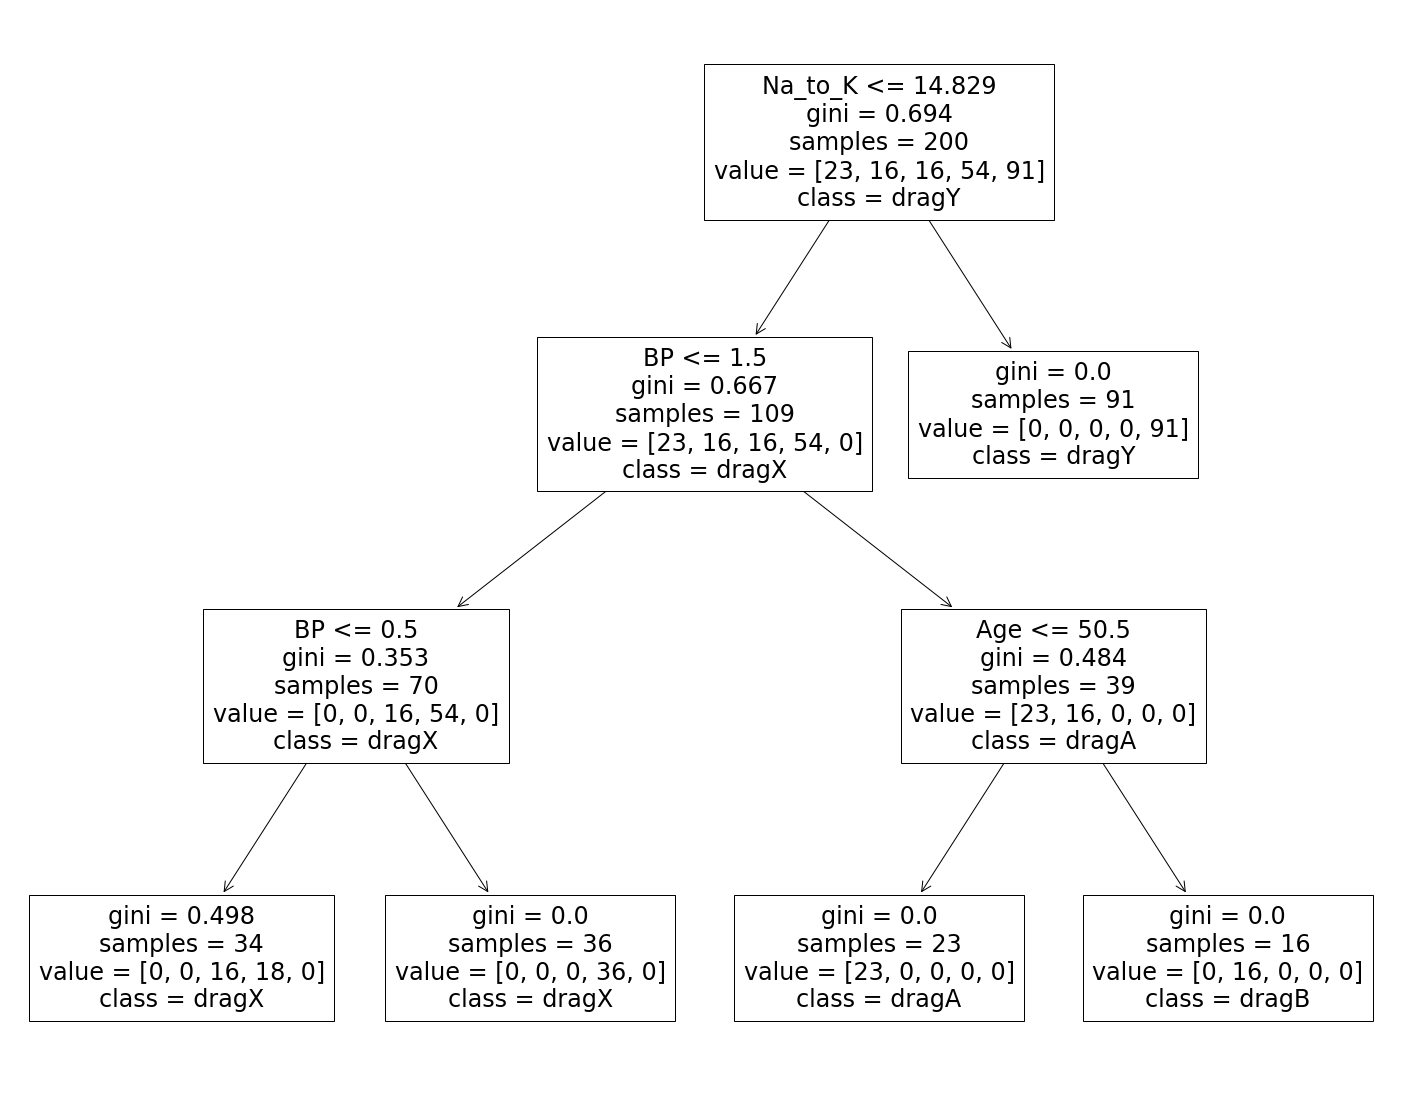

In [7]:
fig = plt.figure(figsize=(25, 20))
tree.plot_tree(model, feature_names=feature_names, class_names=target_names)
fig.savefig('tree.png')
fig.show

In [8]:
pyDatalog.create_terms('X, Y, label, Age, BP, Na_to_K')

In [9]:
(label[X] == 'dragA')
(label[X] == 'dragA') <= (Age[X] <= 50.5)
(label[X] == 'dragX')
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83) & (BP[X] <= 1.5) & (BP[X] <= 0.5)
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83) & (BP[X] <= 1.5)
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83)
(label[X] == 'dragA')
(label[X] == 'dragA') <= (Age[X] <= 50.5)
(label[X] == 'dragX')
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83) & (BP[X] <= 1.5) & (BP[X] <= 0.5)
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83) & (BP[X] <= 1.5)
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83)

label[1]==(*,X,'dragX') <= Na_to_K[1]<=(*,X,'14.83

In [10]:
Age[0] = 23.0
BP[0] = 2.0
Na_to_K[0] = 25.355

In [11]:
dump(model, 'tree.joblib')

['tree.joblib']

In [12]:
model = load('tree.joblib')
classes = model.classes_
tree = model.tree_

n_nodes = tree.node_count
children_left = tree.children_left
children_right = tree.children_right
feature = tree.feature
threshold = tree.threshold
value = tree.value

In [13]:
def get_paths(paths):
    for path in paths:
        left = children_left[path[-1]]
        right = children_right[path[-1]]
        if left != right:
            paths.remove(path)
            paths.append(path + [left])
            #paths.append(path + [right])
            paths.append([right])
            get_paths(paths)
    return paths

paths = [[0]]
paths = get_paths(paths)
paths

[[8], [0, 1, 2, 3], [4], [5, 6], [7]]

In [ ]:
rules = []
for path in paths:
    conjuncts = []
    for i in range(len(path)):
        node = path[i]
        if node == path[-1]:
            samples = list(value[node][0])
            label = samples.index(max(samples))
        else:
            conjunct = {'feature': feature[node], 
                       'threshold': round(threshold[node], 2)}
            child = path[i + 1]
            if child in children_left:
                conjunct['comparison'] = '<='
            else:
                conjunct['comparison'] = '>'
            conjuncts.append(conjunct)
    rules.append({'label': label, 'conjuncts': conjuncts})

rules

In [15]:
def format_name(name):
    name = str(name)
    name = name.replace(' ', '_')
    name = name.replace('(', '')
    name = name.replace(')', '')
    return name

feature_names = [format_name(x) for x in feature_names]
target_names = [f"'{x}'" for x in target_names]

In [ ]:
tmplts = []
for rule in rules:
    label = target_names[rule['label']]
    tmplt_label = f'(label[X] == {label})'
    conjuncts = rule['conjuncts']
    if conjuncts:
        conditions = []
        for conjunct in conjuncts:
            feature_name = feature_names[conjunct['feature']]
            conditions.append(f'({feature_name}[X] {conjunct["comparison"]} {conjunct["threshold"]})')
            tmplt_condition = ' & '.join(conditions)
            tmplts.append(f'{tmplt_label} <= {tmplt_condition}')
        else:
            tmplts.append(tmplt_label)

tmplts

In [17]:
feature_indices = [x for x in set(feature) if x>= 0]
print(feature_indices)
print(feature_names)
predicates = ', '.join([feature_names[x] for x in feature_indices])
print('X, Y, label, ' + predicates)
pyDatalog.create_terms('X, Y, label, ' + predicates)

[0, 2, 4]
['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug']
X, Y, label, Age, BP, Na_to_K


In [18]:
tmplts.reverse()
knowledge = """\n""".join(tmplts)
print(knowledge)
pyDatalog.load(""" 
""" +knowledge + """ 
""")
print(knowledge)

(label[X] == 'dragA')
(label[X] == 'dragA') <= (Age[X] <= 50.5)
(label[X] == 'dragX')
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83) & (BP[X] <= 1.5) & (BP[X] <= 0.5)
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83) & (BP[X] <= 1.5)
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83)
(label[X] == 'dragA')
(label[X] == 'dragA') <= (Age[X] <= 50.5)
(label[X] == 'dragX')
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83) & (BP[X] <= 1.5) & (BP[X] <= 0.5)
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83) & (BP[X] <= 1.5)
(label[X] == 'dragX') <= (Na_to_K[X] <= 14.83)


In [19]:
x = 0 
row = dataX.iloc[x]
for i in feature_indices:
    fact = f'{feature_names[i]}[{x}] = {row[i]}'
    print(fact)
    exec(fact)

Age[0] = 23.0
BP[0] = 2.0
Na_to_K[0] = 25.355


In [20]:
print(pyDatalog.ask('label[X] == Y'))

{(0, 'dragA')}
